- Welcome to Quantitative and High Frequency Trading Training Program
- In this week, we will


- change time frame from "night to day" to "day to night"
- test the first predictive signal;
- plot the pnl cureve and calculate return, sharpe ratio, maximum drawdown, etc statistics;
- test in-sample and out-of-sample results;
- change length of look-back period and test the result;


- Now let's go over the first part
- change time frame from "night to day" to "day to night"


- The night session starts at 20:59:00


- Change the path of helper.r if needed

In [1]:
from helper_week_02 import *
print(HEAD_PATH)
print(DATA_PATH)

d:/intern
d:/intern/pkl tick/


In [2]:
## if change information in helper_week_02 then
import helper_week_02
from imp import reload   
reload(helper_week_02)

<module 'helper_week_02' from 'C:\\Users\\dell\\helper_week_02.py'>

- number of cores, set this number according to your computer

In [3]:
CORE_NUM = 16

- sample product, you can change to your specific product symbol

In [4]:
product = "j"

- get all of the dates

In [5]:
all_dates = get_dates(product)

- initial of the dates

In [6]:
all_dates[:6]
## [1] "20151201" "20151202" "20151203" "20151204" "20151207" "20151208"

['20151201', '20151202', '20151203', '20151204', '20151207', '20151208']

- end of the dates

In [7]:
all_dates[-6:]
## [1] "20180824" "20180827" "20180828" "20180829" "20180830" "20180831"

['20181126', '20181127', '20181128', '20181129', '20181130', '20181203']

- total number of dates

In [8]:
len(all_dates)
## [1] 733

733

-  we can check that some of the data has only day session

In [9]:
for date in all_dates:
    data = get_data(product, date)
    if sum(data["time"]>="21:00:00")==0:
        print(date)
# 20160104 
# 20160215 
# 20160405 
# 20160503 
# 20160613 
# 20160919 
# 20161010 
# 20170103 
# 20170203 
# 20170405 
# 20170502 
# 20170531 
# 20171009 
# 20180102 
# 20180222 
# 20180409 
# 20180619 
# 20180925
# 20181008
        
## we can see that after holidays there is usually only morning session

20160104
20160215
20160405
20160503
20160613
20160919
20161010
20170103
20170203
20170331
20170405
20170502
20170531
20171009
20180102
20180222
20180409
20180619
20180925
20181008


- we can also check that, if there is a night session, then there is day session before

In [10]:
for date in all_dates[1:]:
    data = get_data(product, date)
    if sum(data["time"]>="21:00:00")>0:
        if sum((data["time"]>="09:00:00") & (data["time"]<="15:00:00"))==0:
            print(date)
## there should be no output

- So we can construct the day-to-night data sets now
- every day has two days' data of current data set


- create directory

- create directory for the product

In [11]:
os.makedirs(HEAD_PATH+"/night pkl tick/"+product, exist_ok=True)

- now merge two day's data into one day

In [12]:
n_days = len(all_dates)
n_days

733

- use multiple cores

In [13]:
import dask
from dask import compute, delayed

In [44]:
%%time
import functools
def write2nightPklFiles(i, product="rb"):
    data = get_data(product, all_dates[i])
    data["good"] = False
    data.loc[(data["time"]>="20:59:00") | (data["time"]<="03:00:00"), "good"] = True
    if sum(data["time"]>="21:00:00")>0:
        pre_data = get_data(product, all_dates[i-1])
        pre_data["good"] = False
        pre_data.loc[(pre_data["time"]>="08:59:00") & (pre_data["time"]<="15:00:02"), "good"] = True
        
        data = pre_data.append(data, ignore_index=True)
            
        save(data, NIGHT_PATH+product+"/"+all_dates[i-1] + ".pkl")

with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(write2nightPklFiles, product=product)
    result = compute([delayed(f_par)(i) for i in range(1,len(all_dates))])[0]

Wall time: 1min 4s


- get the list of this form

In [14]:
import os
night_list = list(map(lambda x: NIGHT_PATH+product+"/"+x, os.listdir(NIGHT_PATH + product)))

- number of days

In [15]:
len(night_list)
# 712
## it's fewer because some days have not night session 

712

- some days may have error because of rolling contracts

In [48]:
%%time

def checkForDifferentContract(file):
    data = load(file)
    return len(data[["contract"]].groupby("contract").max())==1

with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    result = compute([delayed(checkForDifferentContract)(file) for file in night_list])[0]

Wall time: 30.2 s


- The following data has two contracts, so it cannot be used directly

In [ ]:
pd.DataFrame(night_list)[list(not x for x in result)]
# 75 	d:/intern/night pkl tick/j/20160325.pkl
# 168 	d:/intern/night pkl tick/j/20160812.pkl
# 237 	d:/intern/night pkl tick/j/20161130.pkl
# 314 	d:/intern/night pkl tick/j/20170329.pkl
# 394 	d:/intern/night pkl tick/j/20170801.pkl
# 472 	d:/intern/night pkl tick/j/20171128.pkl
# 555 	d:/intern/night pkl tick/j/20180409.pkl
# 637 	d:/intern/night pkl tick/j/20180808.pkl

- now remaining days are

In [16]:
sum(result)
## 704

NameError: name 'result' is not defined

In [61]:
good_night = pd.DataFrame(data={"file.path": night_list, "good.night": result})

- we can save the data so next time we can use it directly

In [62]:
os.makedirs(HEAD_PATH+"/good night pkl", exist_ok=True)
save(good_night, HEAD_PATH+"/good night pkl/"+product+".pkl")

- load the good.night data

In [17]:
good_night = load(HEAD_PATH+"/good night pkl/"+product+".pkl")

- In practice we know whether a day has night session or rolling contract
- so we didn't use "future data" here


- now it's see why we use this kind of data

In [18]:
good_night_list = good_night[good_night["good.night"]==True]
n_good_night = len(good_night_list)
print(n_good_night)
## 704

704


- we randomly choose a day

In [19]:
data = load(good_night_list.iloc[599]["file.path"])

- plot all the data

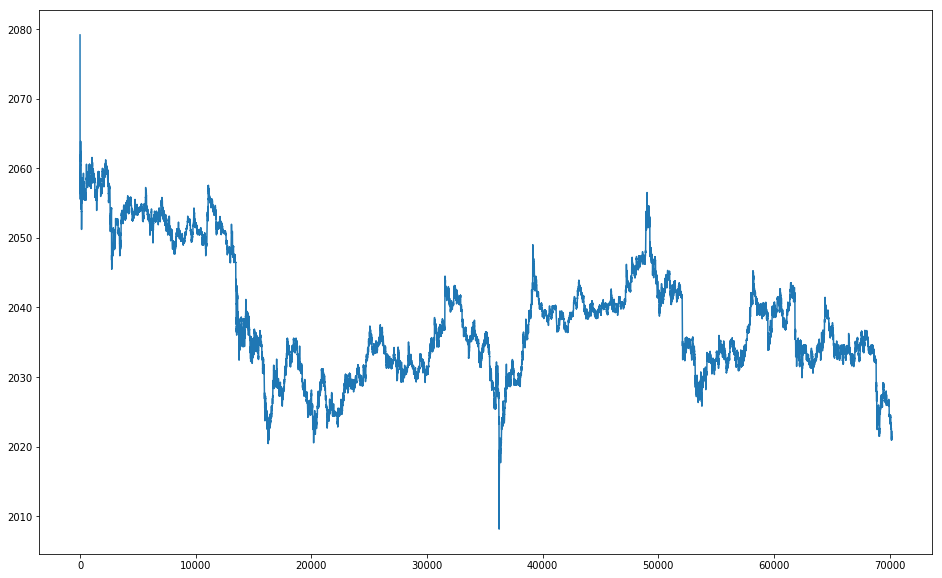

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the data to be used in red

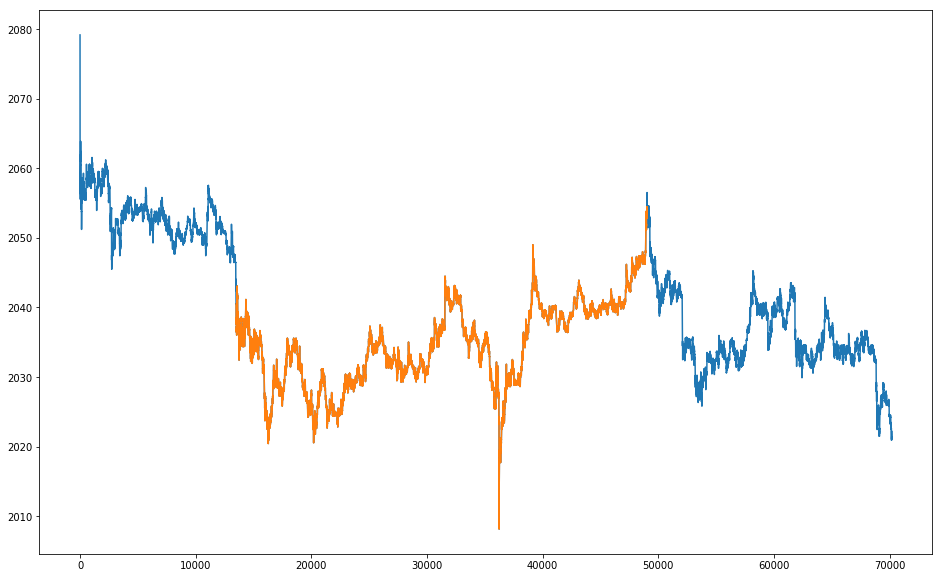

In [71]:
plt.figure(1, figsize=(16, 10))
plt.plot(data.reset_index()["wpr"]);
plt.plot(data.reset_index()[data.reset_index()["good"]]["wpr"]);

- number of usable points

In [21]:
sum(data["good"])
## 35524

35524

- total number of two days

In [22]:
len(data)
## 70184

70184

- so we only use the middle part of the data


- test the first predictive signal
- we can use look-back period of 2048 at first

In [23]:
period = 2048

- the first signal is the buy/sell imbalance signal


- create directory for all signals

- create directory for the product

In [24]:
os.makedirs(HEAD_PATH + "/tmp pkl/" + product, exist_ok=True)

- create directory for the signal

In [25]:
os.makedirs(HEAD_PATH + "/tmp pkl/" + product + "/trade.imb." + str(period), exist_ok=True)

- now let's check the signal


- it's the buy/sell imbalance of one tick

In [26]:
imb = zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"])

- zero_divide is zero when denominator is zero
- we can see the definition of zero_divide in helper.py


- returns 0 if the numerator or denominator is 0

In [27]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

- we can check the result

In [28]:
sum(np.isnan(imb))
## 0

0

- so the result shows that the imb has no bad values
- However, if we simply use "/" rather than zero_divide

In [29]:
bad_imb = (data["buy.trade"] - data["sell.trade"]) / (data["buy.trade"] + data["sell.trade"])

- check the bad.imb

In [30]:
sum(np.isnan(bad_imb))
## 18567
## so there are so many bad values which may cause error when we use this signal

18567

- now use the ewma to get exponential moving average of the value

In [31]:
#pd.set_option('precision', 10)
total_imb = ewma(imb, period)

- check the result

In [32]:
sum(np.isnan(total_imb))
## 0
## so the result contains no bad values

0

- check the length of the signal

In [33]:
len(total_imb)
## 70184

70184

In [34]:
data.shape

(70184, 31)

- we can see that they are the same
- so the signal calculation process is correct


- now let's plot the singal

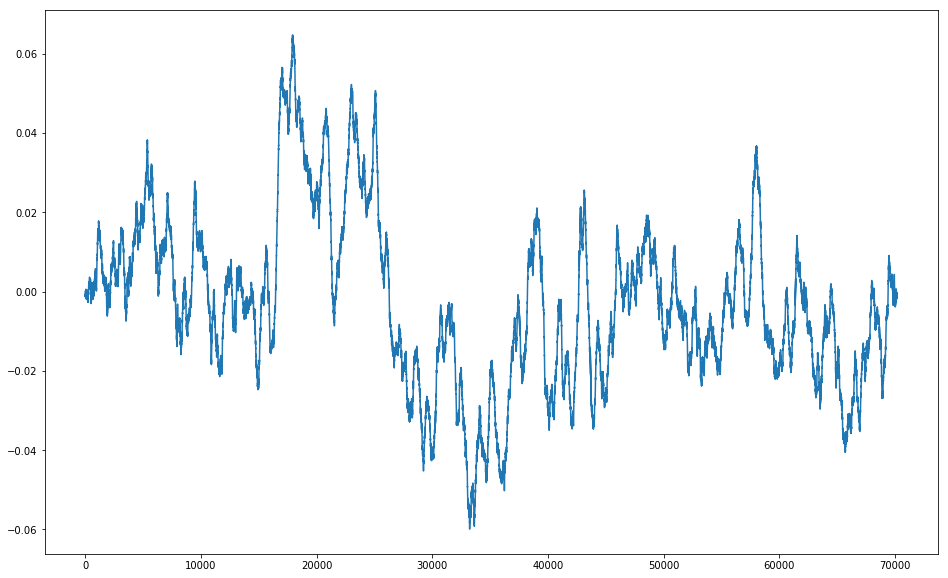

In [ ]:
plt.figure(1, figsize=(16, 10))
plt.plot(total_imb.values);

- we only need the middle part of the signal
- when using ewma, the first 1:(period-1) values are usually not good
- that's because there are not enough data to get accurate result
- when the period is large, it would make many data points useless
- that's one of the reason why we add previous day's data to our data set


- somebody argue that we can use normalized ewma
- but that would make the calculation process more complicate
- so here use simply add one more day's data instead


- let's see the definition of ewma


- ewma

- we can see the formula we use and the filter coefficient
- the values are similar to simple moving average
- but the calculation is much faster

In [36]:
'''
## exponentially weighted moving average
ewma <- function(x, halflife, init = 0) {
  ## S_t = lambda S_t-1 + (1 - lambda) X_t
  lambda <- 1 - 0.5^(1 / halflife)
  filter(lambda * x, filter = 1 - lambda,
                          method = "recursive", init = init)
}
'''

'\n## exponentially weighted moving average\newma <- function(x, halflife, init = 0) {\n  ## S_t = lambda S_t-1 + (1 - lambda) X_t\n  lambda <- 1 - 0.5^(1 / halflife)\n  filter(lambda * x, filter = 1 - lambda,\n                          method = "recursive", init = init)\n}\n'

- now we can the simple moving avergage

In [37]:
sma = cum(imb, period) / period

- check the coefficient of the two signals

In [38]:
np.corrcoef(sma[data["good"]], total_imb[data["good"]])
##   0.83381315
## so these two signals are highly correlated
## but in practice ewma may be better than sma
## because sma requries save the history of data
## while ewma only needs to save the newest data
## when computing sma we need to minus the first data and add the new data
## so we need to save the history of 2048 data(here period is 2048)
## it may be inefficient for high frequency trading

array([[1.        , 0.83381315],
       [0.83381315, 1.        ]])

- plot the useful part of the signal

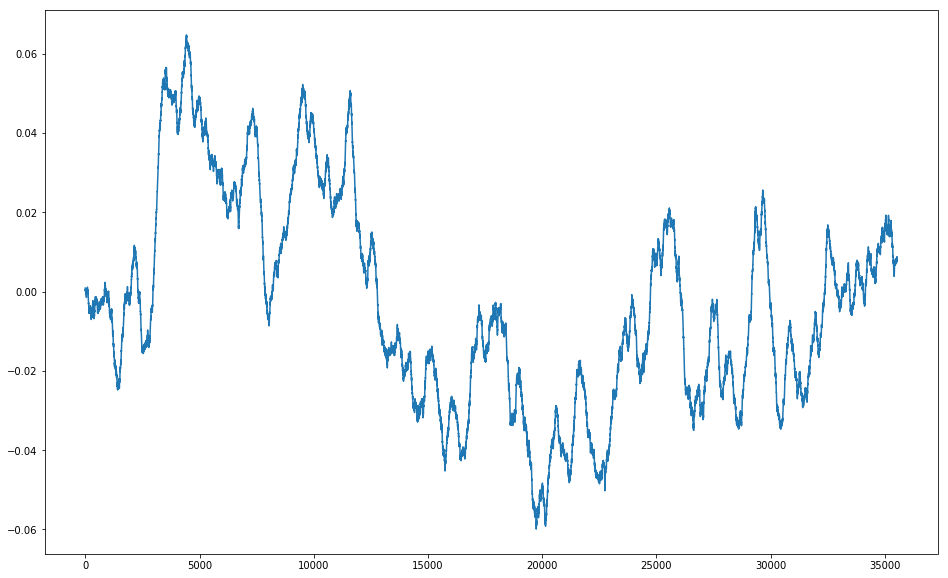

In [39]:
plt.figure(1, figsize=(16, 10))
plt.plot(total_imb[data["good"]].values);
## we can see that it's not very stationary

- check correcness

In [40]:
sum(np.isnan(total_imb))
## 0

0

In [41]:
np.mean(total_imb)
## [1] -0.0029562735205810003

-0.0029562735205810003

- now calcualte all the value of this signal

In [45]:
import functools

In [69]:

%%time

def get_trade_imb(file, product, period):
    data = load(file)

    imb = zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"])
    total_imb = ewma(imb, period)
    S = total_imb[data["good"]].values
    
    save(S, HEAD_PATH+"/tmp pkl/"+product+"/trade.imb."+str(period)+"/" + file[-12:])
    

with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_trade_imb, product=product, period=period)
    result = compute([delayed(f_par)(file) for file in good_night_list["file.path"]])[0]

Wall time: 25.3 s


- check the result

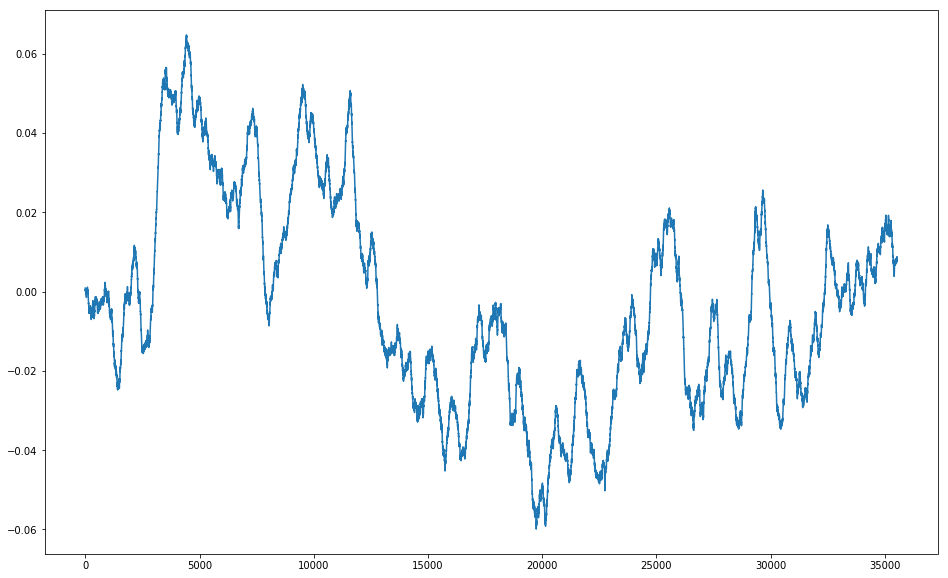

In [70]:
S = load(HEAD_PATH+"/tmp pkl/j/trade.imb.2048/20180626.pkl")

plt.figure(1, figsize=(16, 10))
plt.plot(S);

- we can check the result

In [48]:
signal = ewma(imb, period)
sum(S != signal[data["good"]].values)
## 0

## so the calculation is correct
## here we only save the values we need

0

- now we can test the performance of this signal


- we can extract the file names from their full names

In [49]:
good_night_files = np.array([x[-12:] for x in good_night_list["file.path"]])
good_night_files[:6]
## [1] "20151201.RData" "20151202.RData" "20151203.RData" "20151204.RData"
## [5] "20151207.RData" "20151208.RData"

array(['20151201.pkl', '20151202.pkl', '20151203.pkl', '20151204.pkl',
       '20151207.pkl', '20151208.pkl'], dtype='<U12')

- we set the signal name

In [50]:
signal_name = "trade.imb.2048"

- we can check the value range of the signal
- for example, we choose one day every 10 days 

In [51]:
to_choose = (np.arange(n_good_night)+1) % 10 == 0

In [71]:
all_signal = np.array([])
for file in good_night_files[to_choose]:
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    all_signal = np.concatenate((all_signal, S), axis=0)

- we can see the total number of all.signal

In [72]:
len(all_signal)
## 2103861

2103861

- we can see the plot of the signal

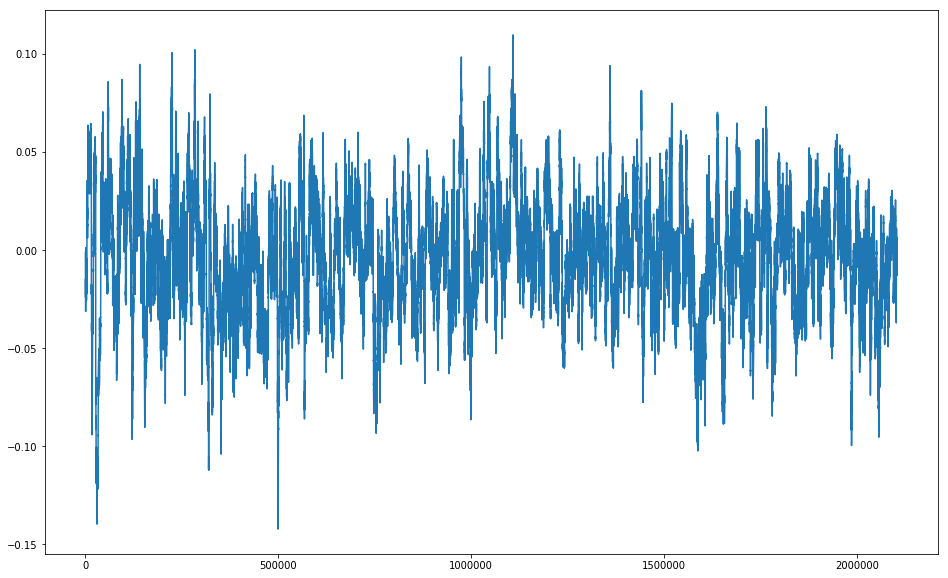

In [54]:
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);
## it's quite stationary as it appears

- the signal is too long, we select portion of 1/period of it

In [55]:
sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
len(sample_signal)
#1027

1027

- we test whether the signal has unit root

In [56]:
import statsmodels.tsa.stattools as ts

In [57]:
result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
result
# (-8.154328454975579,
#  3.1426099355023875e-11,
#  10,
#  1016,
#  {'1%': -3.967708199092398,
#   '5%': -3.414820056748954,
#   '10%': -3.129598705580359}

## so it's stationary and is good for us
## for adf.test, there are two results: stationary or explosive
## explosive is bad and stationary is good

(-8.154328454975579,
 3.1426099355023875e-11,
 10,
 1016,
 {'1%': -3.967708199092398,
  '5%': -3.414820056748954,
  '10%': -3.129598705580359})

- now we can get the range of the signal values
- we can set the quantile points at frst

In [58]:
quantile_ps = list(np.arange(1,5) * 0.01) + list(np.arange(5,20) * 0.05) + [0.96,0.97,0.98,0.99]

- then at the quantile values

In [59]:
pd.Series(all_signal).quantile(quantile_ps)
# 0.01   -0.078472
# 0.02   -0.068325
# 0.03   -0.061092
# 0.04   -0.055831
# 0.25   -0.023405
# 0.30   -0.018834
# 0.35   -0.014535
# 0.40   -0.010552
# 0.45   -0.006823
# 0.50   -0.003132
# 0.55    0.000324
# 0.60    0.003674
# 0.65    0.007271
# 0.70    0.011187
# 0.75    0.015761
# 0.80    0.020598
# 0.85    0.026385
# 0.90    0.034097
# 0.95    0.045561
# 0.96    0.048632
# 0.97    0.052184
# 0.98    0.056687
# 0.99    0.066518

0.01   -0.078472
0.02   -0.068325
0.03   -0.061092
0.04   -0.055831
0.25   -0.023405
0.30   -0.018834
0.35   -0.014535
0.40   -0.010552
0.45   -0.006823
0.50   -0.003132
0.55    0.000324
0.60    0.003674
0.65    0.007271
0.70    0.011187
0.75    0.015761
0.80    0.020598
0.85    0.026385
0.90    0.034097
0.95    0.045561
0.96    0.048632
0.97    0.052184
0.98    0.056687
0.99    0.066518
dtype: float64

- it seems the signal value leans to negative

In [60]:
np.mean(all_signal)
## -0.0037714251156076048

-0.0037714251156076048

In [61]:
np.median(all_signal)
## -0.0031317881619003164

-0.0031317881619003164

- now we write the code to calcualte pnl accordign to week 1's code

- we get a vector of open threshold

In [62]:
open_thre = np.quantile(abs(all_signal), np.arange(0.7, 0.98, 0.02))
open_thre

# array([0.03044908, 0.03177713, 0.03317289, 0.03462175, 0.03625767,
#        0.03805103, 0.03994442, 0.04192011, 0.04399497, 0.04639052,
#        0.04906155, 0.0520916 , 0.05621452, 0.06300016, 0.07386922])

array([0.03044908, 0.03177713, 0.03317289, 0.03462175, 0.03625767,
       0.03805103, 0.03994442, 0.04192011, 0.04399497, 0.04639052,
       0.04906155, 0.0520916 , 0.05621452, 0.06300016, 0.07386922])

In [63]:
from collections import OrderedDict
thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

In [73]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, HEAD_PATH="d:/intern"):
    ## load data
    data = load(HEAD_PATH+"/night pkl tick/"+product+"/"+file)
    data = data[data["good"]]
    #n_bar = len(data)
    
    ## load signal
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)

    ## we don't know the signal is positive correlated or negative correlated  
    pred = S*reverse
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0)]), index=thre_mat.index)
    
    for thre in thre_mat.iterrows():
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0)] = 0
        position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0)] = 0
        position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = (data["ask"][change_buy])*(1+tranct)
        change_base[change_sell] = (data["bid"][change_sell])*(1-tranct)
        final_pnl = -sum(change_base*change_pos)

        num = sum((position!=0) & (change_pos!=0))
        
        if num == 0:
            avg_pnl = 0
            final_pnl = 0
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
            
    return result

In [74]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat)
    result = compute([delayed(f_par)(file) for file in good_night_files])[0]

Wall time: 1min 13s


In [75]:
trade_stat = get_hft_summary(result, thre_mat, n_good_night)
trade_stat["final.result"]

#  	open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.030449 	-0.030449 	1900 	-1.712547 	-3253.839630 	-1.823500 	3263.203835 	3544.276855 	-0.918055
# 1 	0.031777 	-0.031777 	1829 	-1.887196 	-3451.681740 	-1.929654 	3461.045945 	3722.619130 	-0.927219
# 2 	0.033173 	-0.033173 	1741 	-1.776301 	-3092.540605 	-1.749958 	3104.971090 	3363.545265 	-0.919429
# 3 	0.034622 	-0.034622 	1634 	-1.514133 	-2474.092920 	-1.477691 	2546.703270 	2765.281735 	-0.894698
# 4 	0.036258 	-0.036258 	1528 	-1.450823 	-2216.857425 	-1.333416 	2321.827540 	2553.397325 	-0.868199
# 5 	0.038051 	-0.038051 	1422 	-1.625671 	-2311.704240 	-1.418570 	2330.679555 	2594.873860 	-0.890873
# 6 	0.039944 	-0.039944 	1334 	-1.832335 	-2444.335070 	-1.524837 	2457.310825 	2672.157560 	-0.914742
# 7 	0.041920 	-0.041920 	1235 	-1.544949 	-1908.011410 	-1.225630 	1919.069990 	2163.496350 	-0.881911
# 8 	0.043995 	-0.043995 	1135 	-1.820525 	-2066.295700 	-1.377372 	2076.131535 	2153.194805 	-0.959642
# 9 	0.046391 	-0.046391 	1042 	-2.006497 	-2090.769755 	-1.424309 	2098.519135 	2143.585595 	-0.975361
# 10 	0.049062 	-0.049062 	933 	-1.900589 	-1773.249590 	-1.249017 	1779.113410 	1779.113410 	-0.996704
# 11 	0.052092 	-0.052092 	819 	-2.206013 	-1806.724460 	-1.354992 	1812.512895 	1827.083390 	-0.988857
# 12 	0.056215 	-0.056215 	696 	-2.366394 	-1647.009885 	-1.300357 	1669.335270 	1757.353045 	-0.937211
# 13 	0.063000 	-0.063000 	504 	-2.595273 	-1308.017615 	-1.262075 	1338.940425 	1338.940425 	-0.976905
# 14 	0.073869 	-0.073869 	314 	-2.725780 	-855.894815 	-1.123829 	907.601390 	911.954225 	-0.938528

## the result is VERY BAD!!!
## but we can see that the avg.pnl is about -1 and -2 
## for j one tick is 0.5, so avg.pnl is about -2 to -4 ticks

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.030449,-0.030449,1900,-1.712547,-3253.839630,-1.823500,3263.203835,3544.276855,-0.918055
1,0.031777,-0.031777,1829,-1.887196,-3451.681740,-1.929654,3461.045945,3722.619130,-0.927219
2,0.033173,-0.033173,1741,-1.776301,-3092.540605,-1.749958,3104.971090,3363.545265,-0.919429
3,0.034622,-0.034622,1634,-1.514133,-2474.092920,-1.477691,2546.703270,2765.281735,-0.894698
4,0.036258,-0.036258,1528,-1.450823,-2216.857425,-1.333416,2321.827540,2553.397325,-0.868199
5,0.038051,-0.038051,1422,-1.625671,-2311.704240,-1.418570,2330.679555,2594.873860,-0.890873
6,0.039944,-0.039944,1334,-1.832335,-2444.335070,-1.524837,2457.310825,2672.157560,-0.914742
7,0.041920,-0.041920,1235,-1.544949,-1908.011410,-1.225630,1919.069990,2163.496350,-0.881911
8,0.043995,-0.043995,1135,-1.820525,-2066.295700,-1.377372,2076.131535,2153.194805,-0.959642
9,0.046391,-0.046391,1042,-2.006497,-2090.769755,-1.424309,2098.519135,2143.585595,-0.975361


- so if we reverse the direction of trades it would be profitable
- let's do it


- we set the reverse to be -1

In [76]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=-1)
    reverse_result = compute([delayed(f_par)(file) for file in good_night_files])[0]

Wall time: 1min 53s


- now we get the reuslt

In [77]:
reverse_trade_stat = get_hft_summary(reverse_result, thre_mat, n_good_night)
reverse_trade_stat["final.result"]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.030449 	-0.030449 	1900 	-0.337284 	-640.840400 	-0.360339 	772.750915 	1220.920210 	-0.524883
# 1 	0.031777 	-0.031777 	1829 	-0.146900 	-268.679980 	-0.150732 	659.420760 	1067.992660 	-0.251575
# 2 	0.033173 	-0.033173 	1741 	-0.256196 	-446.037690 	-0.252769 	699.338550 	1274.635595 	-0.349933
# 3 	0.034622 	-0.034622 	1634 	-0.527289 	-861.590445 	-0.513906 	991.794260 	1300.124890 	-0.662698
# 4 	0.036258 	-0.036258 	1528 	-0.574513 	-877.855995 	-0.527254 	1077.939045 	1612.008250 	-0.544573
# 5 	0.038051 	-0.038051 	1422 	-0.413293 	-587.702260 	-0.359592 	867.116540 	1219.018645 	-0.482111
# 6 	0.039944 	-0.039944 	1334 	-0.206022 	-274.833475 	-0.170974 	562.835720 	964.558555 	-0.284932
# 7 	0.041920 	-0.041920 	1235 	-0.484220 	-598.011850 	-0.382763 	889.717705 	1041.980780 	-0.573918
# 8 	0.043995 	-0.043995 	1135 	-0.203783 	-231.293940 	-0.153581 	643.876630 	983.668360 	-0.235134
# 9 	0.046391 	-0.046391 	1042 	-0.019931 	-20.768545 	-0.014089 	507.390005 	1069.862380 	-0.019412
# 10 	0.049062 	-0.049062 	933 	-0.141746 	-132.249260 	-0.092831 	406.305620 	966.862945 	-0.136782
# 11 	0.052092 	-0.052092 	819 	0.165784 	135.777465 	0.101433 	166.657585 	848.650385 	0.159992
# 12 	0.056215 	-0.056215 	696 	0.325420 	226.492260 	0.178117 	155.482500 	909.171385 	0.249119
# 13 	0.063000 	-0.063000 	504 	0.571400 	287.985465 	0.278173 	37.337360 	696.807615 	0.413293
# 14 	0.073869 	-0.073869 	314 	0.732825 	230.106945 	0.302216 	115.767145 	448.979390 	0.512511
## now we can see that it's much better

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.030449,-0.030449,1900,-0.337284,-640.840400,-0.360339,772.750915,1220.920210,-0.524883
1,0.031777,-0.031777,1829,-0.146900,-268.679980,-0.150732,659.420760,1067.992660,-0.251575
2,0.033173,-0.033173,1741,-0.256196,-446.037690,-0.252769,699.338550,1274.635595,-0.349933
3,0.034622,-0.034622,1634,-0.527289,-861.590445,-0.513906,991.794260,1300.124890,-0.662698
4,0.036258,-0.036258,1528,-0.574513,-877.855995,-0.527254,1077.939045,1612.008250,-0.544573
5,0.038051,-0.038051,1422,-0.413293,-587.702260,-0.359592,867.116540,1219.018645,-0.482111
6,0.039944,-0.039944,1334,-0.206022,-274.833475,-0.170974,562.835720,964.558555,-0.284932
7,0.041920,-0.041920,1235,-0.484220,-598.011850,-0.382763,889.717705,1041.980780,-0.573918
8,0.043995,-0.043995,1135,-0.203783,-231.293940,-0.153581,643.876630,983.668360,-0.235134
9,0.046391,-0.046391,1042,-0.019931,-20.768545,-0.014089,507.390005,1069.862380,-0.019412


- now let's explain the meaning of each column
- open: open threshold
- close: close threshold, here it's the same as open threshold
- num: number of trades, one open + one close = one trade
- avg.pnl: average pnl of each trade, its unit is price point
- total.pnl: total pnl of the strategy
- sharpe: sharpe rato of the strategy
- drawdown: recent drawdown
- max.drawdon: maximum drawdown
- mar: total.pnl/max.drawdown

- number of strategies

In [78]:
n_thre = len(thre_mat)
n_thre

15

- ratio of profitable strategies

In [79]:
sum(reverse_trade_stat["final.result"]["total.pnl"]>0)/n_thre
## 0.26666666666666666

0.26666666666666666

- so only a few of the strategies are profitable
- we can change the threshold so that it does not depend on the values 

In [104]:
open_thre = np.arange(0.05, 0.102, 0.002)
thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))

In [105]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=-1)
    reverse_result = compute([delayed(f_par)(file) for file in good_night_files])[0]

Wall time: 1min 12s


- for example we care about the average pnl

In [106]:
reverse_trade_stat = get_hft_summary(reverse_result, thre_mat, n_good_night)

good_strat = reverse_trade_stat["final.result"]["avg.pnl"]>2

- let's wee the result

In [107]:
reverse_trade_stat["final.result"][good_strat]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 15 	0.080 	-0.080 	228 	2.144018 	488.836105 	0.757148 	33.120700 	311.265260 	1.570481
# 16 	0.082 	-0.082 	207 	2.642581 	547.014265 	0.869728 	89.586095 	261.579190 	2.091199
# 17 	0.084 	-0.084 	191 	2.829483 	540.431220 	0.895798 	87.586315 	270.524800 	1.997714
# 18 	0.086 	-0.086 	175 	3.047082 	533.239325 	0.904975 	64.565410 	266.025295 	2.004469
# 19 	0.088 	-0.088 	154 	3.035239 	467.426835 	0.830829 	28.537575 	263.369465 	1.774795
# 20 	0.090 	-0.090 	138 	4.372840 	603.451860 	1.152762 	29.537685 	179.199505 	3.367486
# 21 	0.092 	-0.092 	120 	4.067090 	488.050755 	1.037529 	27.037410 	161.144355 	3.028656
# 22 	0.094 	-0.094 	108 	4.403169 	475.542265 	1.032725 	34.820850 	173.167375 	2.746142
# 23 	0.096 	-0.096 	93 	3.716016 	345.589505 	0.782780 	33.930390 	164.706915 	2.098209
# 24 	0.098 	-0.098 	85 	3.883039 	330.058345 	0.749715 	46.553905 	157.740350 	2.092415
# 25 	0.100 	-0.100 	77 	3.819509 	294.102160 	0.701270 	12.105430 	215.323765 	1.365860

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
15,0.080,-0.080,228,2.144018,488.836105,0.757148,33.120700,311.265260,1.570481
16,0.082,-0.082,207,2.642581,547.014265,0.869728,89.586095,261.579190,2.091199
17,0.084,-0.084,191,2.829483,540.431220,0.895798,87.586315,270.524800,1.997714
18,0.086,-0.086,175,3.047082,533.239325,0.904975,64.565410,266.025295,2.004469
19,0.088,-0.088,154,3.035239,467.426835,0.830829,28.537575,263.369465,1.774795
20,0.090,-0.090,138,4.372840,603.451860,1.152762,29.537685,179.199505,3.367486
21,0.092,-0.092,120,4.067090,488.050755,1.037529,27.037410,161.144355,3.028656
22,0.094,-0.094,108,4.403169,475.542265,1.032725,34.820850,173.167375,2.746142
23,0.096,-0.096,93,3.716016,345.589505,0.782780,33.930390,164.706915,2.098209
24,0.098,-0.098,85,3.883039,330.058345,0.749715,46.553905,157.740350,2.092415


- let's plot them

- first we get the dates

In [108]:
date_str = [n[0:8] for n in good_night_files]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

- then we computer the average pnl of selected strategies

In [109]:
good_pnl = reverse_trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)

- at last we plot the selected pnl

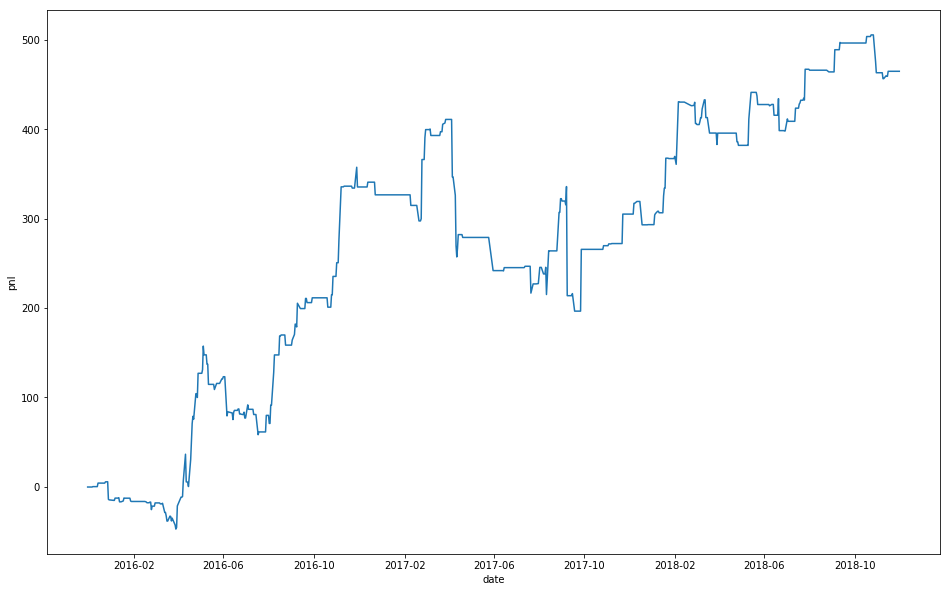

In [110]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates, good_pnl.cumsum());

- we can check its sharp ratio

In [111]:
sharpe(good_pnl)
## 0.9641411975845682

0.9641411975845682

- now let's see the in-sample and out-of-sample performance


- the previous result used the whole data set 
- so it may be more optimistic than reality
- now we split the data into training sample and test sample


- at first let's remain 2018 as out-of-sample

- get training samples

In [117]:
train_sample = good_night_files<"2018"

- number of training samples

In [118]:
sum(train_sample)
## 490

489

- get testing samples

In [119]:
test_sample = good_night_files>"2018"
sum(test_sample)
## 157

215

In [120]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=-1)
    train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 1min 5s


In [121]:
train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
train_stat["final.result"]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.050 	-0.050 	588 	0.163044 	95.869810 	0.097095 	277.940070 	918.259820 	0.104404
# 1 	0.052 	-0.052 	537 	-0.247964 	-133.156635 	-0.144662 	432.091740 	849.650165 	-0.156719
# 2 	0.054 	-0.054 	500 	0.077952 	38.975935 	0.043198 	288.526575 	780.573905 	0.049932
# 3 	0.056 	-0.056 	454 	0.140600 	63.832310 	0.071420 	266.147530 	880.430000 	0.072501
# 4 	0.058 	-0.058 	413 	0.766345 	316.500575 	0.390273 	24.909810 	738.847785 	0.428370
# 5 	0.060 	-0.060 	373 	0.704816 	262.896370 	0.351952 	151.636335 	737.327170 	0.356553
# 6 	0.062 	-0.062 	345 	0.404162 	139.435780 	0.194282 	183.112485 	726.444850 	0.191943
# 7 	0.064 	-0.064 	325 	0.296540 	96.375570 	0.132377 	269.615350 	673.871180 	0.143018
# 8 	0.066 	-0.066 	303 	0.894379 	270.996690 	0.389342 	118.727075 	572.780640 	0.473125
# 9 	0.068 	-0.068 	286 	1.155919 	330.592820 	0.492732 	149.343720 	567.663050 	0.582375
# 10 	0.070 	-0.070 	262 	0.680864 	178.386325 	0.277284 	205.221260 	536.569325 	0.332457
# 11 	0.072 	-0.072 	238 	0.654389 	155.744550 	0.254385 	153.960875 	487.648080 	0.319379
# 12 	0.074 	-0.074 	218 	0.045481 	9.914895 	0.017712 	317.906950 	448.479335 	0.022108
# 13 	0.076 	-0.076 	193 	0.301988 	58.283685 	0.111313 	191.000860 	344.277810 	0.169293
# 14 	0.078 	-0.078 	181 	0.527310 	95.443115 	0.187424 	120.128330 	328.151745 	0.290851
# 15 	0.080 	-0.080 	163 	1.066000 	173.757980 	0.375109 	200.395395 	311.265260 	0.558231
# 16 	0.082 	-0.082 	152 	1.764654 	268.227370 	0.578011 	170.240175 	261.579190 	1.025416
# 17 	0.084 	-0.084 	142 	2.328947 	330.710515 	0.736439 	183.408785 	270.524800 	1.222478
# 18 	0.086 	-0.086 	133 	2.925995 	389.157350 	0.871548 	163.409665 	266.025295 	1.462858
# 19 	0.088 	-0.088 	115 	2.355248 	270.853480 	0.641529 	157.909365 	263.369465 	1.028416
# 20 	0.090 	-0.090 	103 	4.005262 	412.542000 	1.068313 	13.274655 	179.199505 	2.302138
# 21 	0.092 	-0.092 	90 	3.714950 	334.345470 	0.956916 	74.935625 	161.144355 	2.074820
# 22 	0.094 	-0.094 	81 	4.340343 	351.567800 	1.019764 	87.421375 	173.167375 	2.030220
# 23 	0.096 	-0.096 	71 	3.594022 	255.175570 	0.765623 	79.960805 	164.706915 	1.549271
# 24 	0.098 	-0.098 	64 	4.034406 	258.201990 	0.772128 	66.979065 	157.740350 	1.636880
# 25 	0.100 	-0.100 	58 	3.117182 	180.796560 	0.565328 	124.062535 	215.323765 	0.839650

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.050,-0.050,588,0.163044,95.869810,0.097095,277.940070,918.259820,0.104404
1,0.052,-0.052,537,-0.247964,-133.156635,-0.144662,432.091740,849.650165,-0.156719
2,0.054,-0.054,500,0.077952,38.975935,0.043198,288.526575,780.573905,0.049932
3,0.056,-0.056,454,0.140600,63.832310,0.071420,266.147530,880.430000,0.072501
4,0.058,-0.058,413,0.766345,316.500575,0.390273,24.909810,738.847785,0.428370
5,0.060,-0.060,373,0.704816,262.896370,0.351952,151.636335,737.327170,0.356553
6,0.062,-0.062,345,0.404162,139.435780,0.194282,183.112485,726.444850,0.191943
7,0.064,-0.064,325,0.296540,96.375570,0.132377,269.615350,673.871180,0.143018
8,0.066,-0.066,303,0.894379,270.996690,0.389342,118.727075,572.780640,0.473125
9,0.068,-0.068,286,1.155919,330.592820,0.492732,149.343720,567.663050,0.582375


In [122]:
good_train = train_stat["final.result"]["avg.pnl"]>2
good_train[good_train == True]
# 17    True
# 18    True
# 19    True
# 20    True
# 21    True
# 22    True
# 23    True
# 24    True
# 25    True
# Name: avg.pnl, dtype: bool

17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
Name: avg.pnl, dtype: bool

- now calculate the result of test samples

In [123]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat, reverse=-1)
    test_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]

Wall time: 27.3 s


- get the test result summary

In [124]:
test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))

- get the result of good training strategies

In [125]:
test_stat["final.result"][good_train]
#  	open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 17 	0.084 	-0.084 	49 	4.280014 	209.720705 	1.394841 	87.586315 	92.077015 	2.277666
# 18 	0.086 	-0.086 	42 	3.430523 	144.081975 	1.059728 	64.565410 	89.115520 	1.616800
# 19 	0.088 	-0.088 	39 	5.040342 	196.573355 	1.449788 	28.537575 	82.676730 	2.377614
# 20 	0.090 	-0.090 	35 	5.454567 	190.909860 	1.414156 	29.537685 	91.520235 	2.085985
# 21 	0.092 	-0.092 	30 	5.123509 	153.705285 	1.299974 	27.037410 	54.588540 	2.815706
# 22 	0.094 	-0.094 	27 	4.591647 	123.974465 	1.105833 	34.820850 	42.307800 	2.930298
# 23 	0.096 	-0.096 	22 	4.109724 	90.413935 	0.872036 	33.930390 	37.426695 	2.415761
# 24 	0.098 	-0.098 	21 	3.421731 	71.856355 	0.715605 	46.553905 	51.550375 	1.393906
# 25 	0.100 	-0.100 	19 	5.963453 	113.305600 	1.207885 	12.105430 	47.129845 	2.404116

## we can see that the result is accpetable

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
17,0.084,-0.084,49,4.280014,209.720705,1.394841,87.586315,92.077015,2.277666
18,0.086,-0.086,42,3.430523,144.081975,1.059728,64.565410,89.115520,1.616800
19,0.088,-0.088,39,5.040342,196.573355,1.449788,28.537575,82.676730,2.377614
20,0.090,-0.090,35,5.454567,190.909860,1.414156,29.537685,91.520235,2.085985
21,0.092,-0.092,30,5.123509,153.705285,1.299974,27.037410,54.588540,2.815706
22,0.094,-0.094,27,4.591647,123.974465,1.105833,34.820850,42.307800,2.930298
23,0.096,-0.096,22,4.109724,90.413935,0.872036,33.930390,37.426695,2.415761
24,0.098,-0.098,21,3.421731,71.856355,0.715605,46.553905,51.550375,1.393906
25,0.100,-0.100,19,5.963453,113.305600,1.207885,12.105430,47.129845,2.404116


- to check the pnl curve

- the dates of test samples

In [126]:
test_dates = format_dates[test_sample]

- pnl of test samples using the strategies selected from training sample

In [127]:
test_pnl = test_stat["daily.pnl"].loc[:, good_train].sum(axis=1)/sum(good_train)

- now plot the pnl cure

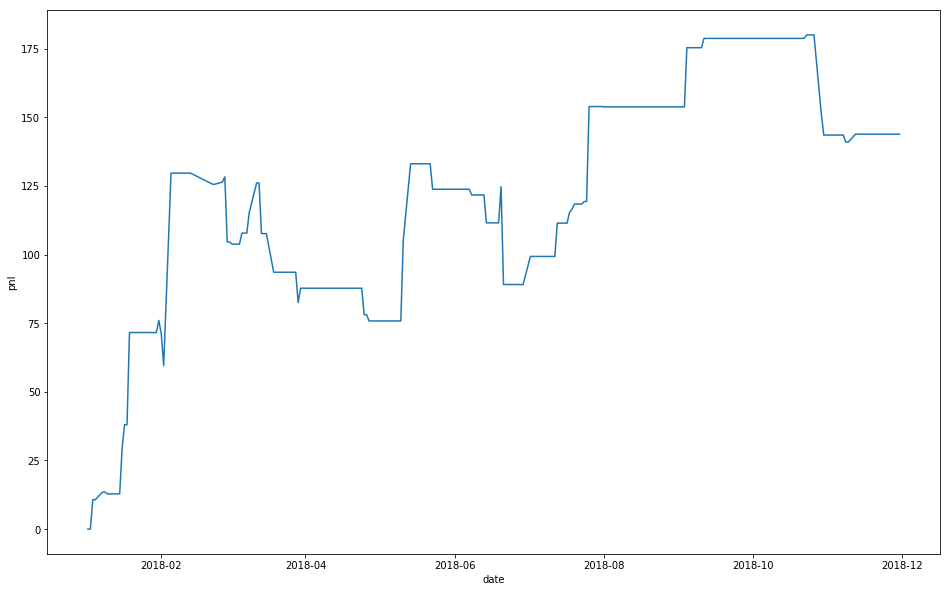

In [128]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(test_dates, test_pnl.cumsum());

- calculate its sharpe ratio

In [129]:
sharpe(test_pnl)
##[1] 1.2952264092321257
## we can see that the sharpe ratio is still better

1.2952264092321257

- since  sharpe ratio is affected by the market 
- its value may not has too much meaning
- we can check its rank


- mean sharp value of good training samples

In [130]:
train_sharp = np.mean(train_stat["final.result"]["sharp"][good_train])
train_sharp
## 0.8219543941204094

0.8219543941204094

- now gets its rank

In [131]:
sum(train_stat["final.result"]["sharp"]>train_sharp)+1
## 5

5

- mean sharp value of test samples

In [132]:
test_sharp = np.mean(test_stat["final.result"]["sharp"][good_train])
test_sharp
## 1.1688717010949166

1.1688717010949166

- now gets its rank

In [133]:
sum(test_stat["final.result"]["sharp"]>test_sharp)+1
## 9

9

- so it's still rank #9
- although test sample sharp ratio is higher than training sample
- we cannot be sure about whether there is overfitting or not
- because maybe the overall market of test sample is better than in-sample 

- some people may argue that when we get the range of thresholds, 


- now get the good samples using these thresholds

- for statistical analysis in finance, if we simply change a little bit of the setup such as the thre.mat here
- we should NOT expect much changes in the result, otherwise we might have overfitted the data


- to use fix thre.mat rather than quantile, we have several advantages
- the range is fixed, so we can calcualte each day's result and save them,
- and we don't need to change too frequently

- until now we have just open thresholds, now we can consider adding close thresholds

- add close thresholds, simply 30%, 60%, and 100% of the open thresholds

In [142]:
from collections import OrderedDict
import itertools
open_list=open_thre[good_train]
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.3, 0.6, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))

- get the thre.mat

In [143]:
thre_list = np.array(thre_list)
close_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
close_thre_mat
## we do this only when the open threshold is good for both open and close
## this can save much time for optimization

,open,close
0,0.084,-0.0252
1,0.084,-0.0504
2,0.084,-0.0840
3,0.086,-0.0258
4,0.086,-0.0516
5,0.086,-0.0860
6,0.088,-0.0264
7,0.088,-0.0528
8,0.088,-0.0880
9,0.090,-0.0270


In [144]:
%%time

with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=close_thre_mat, reverse=-1)
    close_train_result = compute([delayed(f_par)(file) for file in good_night_files[train_sample]])[0]

Wall time: 35.4 s


In [145]:
close_train_stat = get_hft_summary(close_train_result, close_thre_mat, sum(train_sample))
close_train_stat["final.result"]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 0 	0.084 	-0.0252 	145 	0.360555 	52.280415 	0.159443 	94.303805 	188.138155 	0.277883
# 1 	0.084 	-0.0504 	142 	2.241065 	318.231250 	0.793378 	174.406585 	250.252485 	1.271641
# 2 	0.084 	-0.0840 	142 	2.328947 	330.710515 	0.736439 	183.408785 	270.524800 	1.222478
# 3 	0.086 	-0.0258 	134 	0.757449 	101.498125 	0.312260 	72.455045 	177.288185 	0.572504
# 4 	0.086 	-0.0516 	133 	2.726864 	362.672915 	0.917747 	178.411535 	247.007100 	1.468269
# 5 	0.086 	-0.0860 	133 	2.925995 	389.157350 	0.871548 	163.409665 	266.025295 	1.462858
# 6 	0.088 	-0.0264 	116 	-0.175063 	-20.307340 	-0.064239 	153.916185 	164.819320 	-0.123210
# 7 	0.088 	-0.0528 	115 	2.546567 	292.855240 	0.776395 	107.418440 	241.815690 	1.211068
# 8 	0.088 	-0.0880 	115 	2.355248 	270.853480 	0.641529 	157.909365 	263.369465 	1.028416
# 9 	0.090 	-0.0270 	104 	1.676702 	174.377000 	0.607305 	29.777900 	119.386240 	1.460612
# 10 	0.090 	-0.0540 	103 	4.291686 	442.043705 	1.314653 	0.000000 	159.145785 	2.777602
# 11 	0.090 	-0.0900 	103 	4.005262 	412.542000 	1.068313 	13.274655 	179.199505 	2.302138
# 12 	0.092 	-0.0276 	91 	2.551210 	232.160120 	0.842955 	8.865925 	129.562610 	1.791876
# 13 	0.092 	-0.0552 	90 	3.953787 	355.840795 	1.169232 	0.000000 	149.645620 	2.377890
# 14 	0.092 	-0.0920 	90 	3.714950 	334.345470 	0.956916 	74.935625 	161.144355 	2.074820
# 15 	0.094 	-0.0282 	82 	3.035144 	248.881845 	0.918254 	8.444840 	115.990150 	2.145715
# 16 	0.094 	-0.0564 	81 	4.167500 	337.567470 	1.100976 	45.928800 	152.644630 	2.211460
# 17 	0.094 	-0.0940 	81 	4.340343 	351.567800 	1.019764 	87.421375 	173.167375 	2.030220
# 18 	0.096 	-0.0288 	72 	2.242821 	161.483125 	0.615163 	14.600150 	112.310810 	1.437824
# 19 	0.096 	-0.0576 	71 	3.805279 	270.174800 	0.906010 	24.466910 	138.683345 	1.948142
# 20 	0.096 	-0.0960 	71 	3.594022 	255.175570 	0.765623 	79.960805 	164.706915 	1.549271
# 21 	0.098 	-0.0294 	65 	2.484803 	161.512185 	0.613379 	28.415670 	139.113135 	1.161013
# 22 	0.098 	-0.0588 	64 	4.182844 	267.702045 	0.893604 	11.485170 	156.186155 	1.713993
# 23 	0.098 	-0.0980 	64 	4.034406 	258.201990 	0.772128 	66.979065 	157.740350 	1.636880
# 24 	0.100 	-0.0300 	59 	2.137434 	126.108625 	0.492838 	45.098300 	144.860465 	0.870552
# 25 	0.100 	-0.0600 	58 	3.427516 	198.795900 	0.700767 	67.068805 	158.330035 	1.255579
# 26 	0.100 	-0.1000 	58 	3.117182 	180.796560 	0.565328 	124.062535 	215.323765 	0.839650

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.084,-0.0252,145,0.360555,52.280415,0.159443,94.303805,188.138155,0.277883
1,0.084,-0.0504,142,2.241065,318.231250,0.793378,174.406585,250.252485,1.271641
2,0.084,-0.0840,142,2.328947,330.710515,0.736439,183.408785,270.524800,1.222478
3,0.086,-0.0258,134,0.757449,101.498125,0.312260,72.455045,177.288185,0.572504
4,0.086,-0.0516,133,2.726864,362.672915,0.917747,178.411535,247.007100,1.468269
5,0.086,-0.0860,133,2.925995,389.157350,0.871548,163.409665,266.025295,1.462858
6,0.088,-0.0264,116,-0.175063,-20.307340,-0.064239,153.916185,164.819320,-0.123210
7,0.088,-0.0528,115,2.546567,292.855240,0.776395,107.418440,241.815690,1.211068
8,0.088,-0.0880,115,2.355248,270.853480,0.641529,157.909365,263.369465,1.028416
9,0.090,-0.0270,104,1.676702,174.377000,0.607305,29.777900,119.386240,1.460612


- get good result
- now we have more parameters and we can expect better result

In [154]:
close_good_train = close_train_stat["final.result"]["avg.pnl"]>2
close_good_train[close_good_train==True]
# 1     True
# 2     True
# 4     True
# 5     True
# 7     True
# 8     True
# 10    True
# 11    True
# 12    True
# 13    True
# 14    True
# 15    True
# 16    True
# 17    True
# 18    True
# 19    True
# 20    True
# 21    True
# 22    True
# 23    True
# 24    True
# 25    True
# 26    True
# Name: avg.pnl, dtype: bool

1     True
2     True
4     True
5     True
7     True
8     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
Name: avg.pnl, dtype: bool

In [155]:
close_good_sharp = np.mean(close_train_stat["final.result"]["sharp"][close_good_train])
close_good_sharp
## 0.8457800859820561

0.8457800859820561

In [156]:
sum(close_train_stat["final.result"]["sharp"]>close_good_sharp)+1
## [1] 12
## so it ranks #12

12

In [149]:
%%time

with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=close_thre_mat, reverse=-1)
    close_test_result = compute([delayed(f_par)(file) for file in good_night_files[test_sample]])[0]

Wall time: 34.5 s


In [157]:
close_test_stat = get_hft_summary(close_test_result, close_thre_mat, sum(test_sample))
close_test_stat["final.result"][close_good_train]

# open 	close 	num 	avg.pnl 	total.pnl 	sharp 	drawdown 	max.drawdown 	mar
# 1 	0.084 	-0.0504 	49 	1.902467 	93.220870 	0.640090 	77.084060 	120.118065 	0.776077
# 2 	0.084 	-0.0840 	49 	4.280014 	209.720705 	1.394841 	87.586315 	92.077015 	2.277666
# 4 	0.086 	-0.0516 	42 	1.037610 	43.579610 	0.336635 	64.565410 	128.449845 	0.339273
# 5 	0.086 	-0.0860 	42 	3.430523 	144.081975 	1.059728 	64.565410 	89.115520 	1.616800
# 7 	0.088 	-0.0528 	39 	2.386455 	93.071760 	0.715793 	28.537575 	118.011385 	0.788668
# 8 	0.088 	-0.0880 	39 	5.040342 	196.573355 	1.449788 	28.537575 	82.676730 	2.377614
# 10 	0.090 	-0.0540 	35 	3.268845 	114.409585 	0.901589 	29.537685 	116.022270 	0.986100
# 11 	0.090 	-0.0900 	35 	5.454567 	190.909860 	1.414156 	29.537685 	91.520235 	2.085985
# 12 	0.092 	-0.0276 	31 	1.829934 	56.727940 	0.592244 	44.961960 	60.326705 	0.940345
# 13 	0.092 	-0.0552 	30 	2.556832 	76.704955 	0.706318 	27.037410 	80.090465 	0.957729
# 14 	0.092 	-0.0920 	30 	5.123509 	153.705285 	1.299974 	27.037410 	54.588540 	2.815706
# 15 	0.094 	-0.0282 	28 	1.678594 	47.000640 	0.507947 	52.937325 	57.428025 	0.818427
# 16 	0.094 	-0.0564 	27 	2.443560 	65.976115 	0.626929 	34.820850 	54.703375 	1.206070
# 17 	0.094 	-0.0940 	27 	4.591647 	123.974465 	1.105833 	34.820850 	42.307800 	2.930298
# 18 	0.096 	-0.0288 	22 	0.996485 	21.922680 	0.242399 	56.927860 	56.927860 	0.385096
# 19 	0.096 	-0.0576 	22 	1.518885 	33.415475 	0.349158 	52.498470 	55.994775 	0.596761
# 20 	0.096 	-0.0960 	22 	4.109724 	90.413935 	0.872036 	33.930390 	37.426695 	2.415761
# 21 	0.098 	-0.0294 	21 	0.207836 	4.364550 	0.051200 	54.427695 	54.427695 	0.080190
# 22 	0.098 	-0.0588 	21 	0.778940 	16.357730 	0.177410 	70.056050 	75.052520 	0.217950
# 23 	0.098 	-0.0980 	21 	3.421731 	71.856355 	0.715605 	46.553905 	51.550375 	1.393906
# 24 	0.100 	-0.0300 	19 	1.779749 	33.815225 	0.450550 	27.102900 	44.846135 	0.754028
# 25 	0.100 	-0.0600 	19 	3.147724 	59.806755 	0.699389 	35.607575 	70.631990 	0.846738
# 26 	0.100 	-0.1000 	19 	5.963453 	113.305600 	1.207885 	12.105430 	47.129845 	2.404116

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
1,0.084,-0.0504,49,1.902467,93.220870,0.640090,77.084060,120.118065,0.776077
2,0.084,-0.0840,49,4.280014,209.720705,1.394841,87.586315,92.077015,2.277666
4,0.086,-0.0516,42,1.037610,43.579610,0.336635,64.565410,128.449845,0.339273
5,0.086,-0.0860,42,3.430523,144.081975,1.059728,64.565410,89.115520,1.616800
7,0.088,-0.0528,39,2.386455,93.071760,0.715793,28.537575,118.011385,0.788668
8,0.088,-0.0880,39,5.040342,196.573355,1.449788,28.537575,82.676730,2.377614
10,0.090,-0.0540,35,3.268845,114.409585,0.901589,29.537685,116.022270,0.986100
11,0.090,-0.0900,35,5.454567,190.909860,1.414156,29.537685,91.520235,2.085985
12,0.092,-0.0276,31,1.829934,56.727940,0.592244,44.961960,60.326705,0.940345
13,0.092,-0.0552,30,2.556832,76.704955,0.706318,27.037410,80.090465,0.957729


In [158]:
close_test_sharp = np.mean(close_test_stat["final.result"]["sharp"][close_good_train])
close_test_sharp
## 0.7616302553075371

0.7616302553075371

In [159]:
sum(close_test_stat["final.result"]["sharp"]>close_test_sharp)+1
##[1] 13

13

- let's check the average pnl

In [160]:
np.mean(close_test_stat["final.result"]["avg.pnl"][close_good_train])
## 2.9108446590984376
## it's worse than before

2.9108446590984376

- we can see that for j with close threshold the result the result is worse
- now we know that with more parameters, we can get better in-sample result, but for out-of-sample it may not be as good

- HOMEWORK:
- 1. change period to 1024 and 4096, repeat the process above
- 2. you only need to use thre fixed threshold rather than the quantile ones
- 3. you can define the values of the thre.mat by yourself
- 4. run result for open=close and open!=close
- 5. detailed format of output to be told, but you just need to give me an .RData which contains all the table


- Good luck